In [1]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [2]:
seed = 0

torch.manual_seed(seed)

In [3]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Reusing dataset imdb (/home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [4]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [5]:
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    length = len(tokens)
    return {'tokens': tokens, 'length': length}

In [6]:
max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-98e263656f586667.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-08f9ff60341e8990.arrow


In [7]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

Loading cached split indices for dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-28b136fb2a4d67fd.arrow and /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-8fa05fb343b1e79a.arrow


In [8]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [9]:
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

In [10]:
vocab.set_default_index(unk_index)

In [11]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

In [12]:
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-631f583ffb0d9c68.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-6f5a6c52dcbaf2d0.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-c455c5d5c41c2779.arrow


In [13]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label', 'length'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label', 'length'])

In [14]:
train_data[0]

{'label': tensor(1),
 'length': tensor(256),
 'ids': tensor([   98,    13,  6329,     6,   559,    13,  6491,     4,     2,   763,
             6,  6300,    17,    34,     7,     2,   195,   116,    98,    40,
          2302,   102,  3497,    44,  3318, 15422,    21,   261,  3609,  3433,
             3,   474,     4,  6093,     6, 10888,    54,   396,  1198,   338,
          4479,     4,    14,    23,  1481,  3596,    19,     5, 13453,   850,
            23,     3,     2,   639,     7,    14,    23,    10,  1073,    20,
          2302,     9,  7180,  9372,     7,  1045,  2522,     4,  1706,  2115,
             4,   212,  8127,     6,  3179,  1485,     3,     2,   386,     7,
         13210,   860,   233,    10,     5, 12948,     8,     2,   984,   212,
           628,   346,    13,  1228,     7,   462,     4,     6,     2,  1236,
          1675,   114,     6,     2,   905,    13, 10802,    59,    71,    35,
          1132,    19,     2,  3009,     4,    13,   117,   771,     4,     8,


In [15]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, 
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [16]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, 
             pad_index)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,073,702 trainable parameters


In [18]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [19]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21543, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [20]:
vectors = torchtext.vocab.FastText()

In [21]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [22]:
model.embedding.weight.data = pretrained_embedding

In [23]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
model = model.to(device)
criterion = criterion.to(device)

In [27]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_length = [i['length'] for i in batch]
    batch_length = torch.stack(batch_length)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'length': batch_length,
             'label': batch_label}
    return batch

In [28]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [29]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        length = batch['length']
        label = batch['label'].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [30]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            length = batch['length']
            label = batch['label'].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [31]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [32]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.70it/s]
epoch: 1
train_loss: 0.632, train_acc: 0.632
valid_loss: 0.470, valid_acc: 0.779
evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.53it/s]
epoch: 2
train_loss: 0.522, train_acc: 0.743
valid_loss: 0.465, valid_acc: 0.775
evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.66it/s]
epoch: 3
train_loss: 0.443, train_acc: 0.804
valid_loss: 0.393, valid_acc: 0.830
evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.67it/s]
epoch: 4
train_loss: 0.369, train_acc: 0.840
valid_loss: 0.367, valid_acc: 0.848
evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.60it/s]
epoch: 5
train_loss: 0.336, train_acc: 0.857
valid_loss: 0.393, valid_acc: 0.842
evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.63it/s]
epoch: 6
train_loss: 0.375, train_acc: 0.837
valid_loss: 0.387, valid_acc: 0.842
evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.56it/s]
epoch: 7
train_loss: 0.368, train_acc: 0.848
valid_loss: 0.437, valid_acc

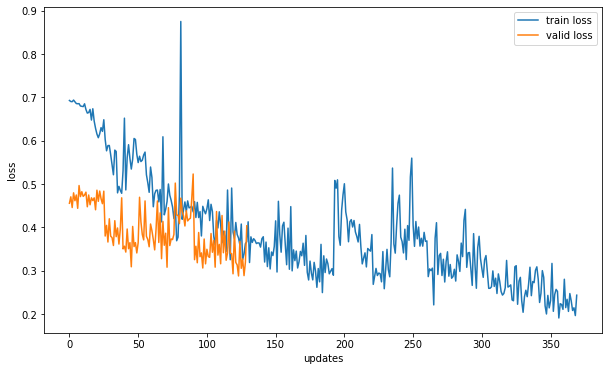

In [33]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

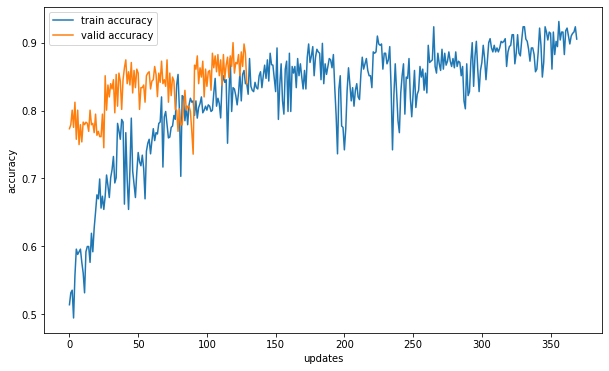

In [34]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [35]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 49/49 [00:06<00:00,  8.03it/s]
test_loss: 0.351, test_acc: 0.859


In [36]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [37]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.8874172568321228)

In [38]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9508437514305115)

In [39]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5246995091438293)

In [40]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5568666458129883)